In [1]:
import pandas as pd
import pandas_profiling

import numpy as np

from math import *

from geopy.distance import geodesic 

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import xgboost

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

1. Загрузите датасет taxi.csv.
2. Отобразите общую информацию по признакам.
3. Выявите пропуски, а также возможные причины их возникновения. Решите, что следует сделать с ними. 
4. Оцените зависимости переменных между собой. Используйте корреляции и profile_report
5. Определите стратегию преобразования категориальных признаков (т.е. как их сделать адекватными для моделей).
6. Найдите признаки, которые можно разделить на другие, или преобразовать в другой тип данных. Удалите лишние, при необходимости.
7. Разделите выборку на обучаемую и тестовую.
8. Обучите модель. Напишите в markdown свои наблюдения по полученным результатам. 
Хорошие результаты дают классификаторы RandomForest и XGBoost

In [2]:
data = pd.read_csv('taxi.csv')
data.duplicated().sum().sum() # дупликатов нет
data.isna().sum().sum()       # пропусков нет
data.head()

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response
0,1105373,5,20,6080,174182,55.818842,37.334562,55.814567,37.355010,-1.000,-1.000,Economy,private,0
1,759733,5,14,6080,358774,55.805342,37.515023,55.819329,37.466398,18.802,25.217,Standard,private,1
2,416977,6,14,6080,866260,55.813978,37.347688,55.814827,37.354074,6.747,9.800,Economy,private,0
3,889660,2,6,6080,163522,55.745922,37.421748,55.743469,37.431130,-1.000,-1.000,Economy,private,1
4,1120055,4,16,6080,506710,55.803578,37.521602,55.812559,37.527407,12.383,19.250,Economy,private,1


In [3]:
pandas_profiling.ProfileReport(data)

C:\Users\admin\Anaconda3\lib\site-packages\pandas_profiling\describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,14
Number of observations,100000
Total Missing (%),0.0%
Total size in memory,10.7 MiB
Average record size in memory,112.0 B
Numeric,9
Categorical,2
Boolean,1
Date,0
Text (Unique),0
Rejected,2


## Пропуски и повторы  /  возможные причины их возникновения

In [4]:
data.isna().sum().sum()       

0

In [5]:
data.duplicated().sum().sum() 

0

Пропусков и повторов в датасете нет

##  Корреляции и зависимости между переменными

В рамках отчета  Profile Report выявлено 2 груммы зависимостей:

- между широтой и долготой географических точек (нахождения водителя и пассажира) в момент подачи заявки. Данные о корреляции не значимы, поскольку широта и долгота геоточки будут использоваться в анализе не сами по себе, а в качестве базыдля расчета расстояния, которое следует преодолеть водителю для того, чтобы приступить к исполнению заказа;

- между дальностью поездки в километрах и продолжительностью движения в минутах - эта зависимость объяснима тем, что средняя скорость движения такси ограничена дорожной обстановкой и ПДД и в среднем величина стабильная.   Следует выбрать наиболее информативную из 2 переменных для включения в модель

##  Стратегия преобразования категориальных переменных

### driver_response

Идеальное распределение бинарной зависимой переменной (50/50), оставляем как есть, преобразований не требуется

In [14]:
data['driver_response'].value_counts()

0    50752
1    49248
Name: driver_response, dtype: int64

###  weekday_key  &  hour_key

посмотрим распределение наблюдений по дням недели и часам на предмет отсутствия очевидных провалов (отсутствия) наблюдений по отдельным сочетаниям признаков

In [6]:
pt_time_с     = pd.pivot_table(data, 
                         values     = ['driver_response'],  
                         index      = ['weekday_key'],
                         columns    = ['hour_key'], 
                         aggfunc    = ['count'])
pt_time_с

count                                               ...  \
            driver_response                                               ...   
hour_key                 0    1    2    3    4    5    6    7    8    9   ...   
weekday_key                                                               ...   
0                      1167  648  547  440  482  410  272  163  200  233  ...   
1                      1610  608  388  249  479  302  261  428  603  478  ...   
2                       621  288  189  160  150  205  197  305  516  509  ...   
3                       527  332  165  110  134  138  147  383  520  482  ...   
4                       613  264  153  120  244  116  129  412  653  556  ...   
5                      1043  569  198  192  313  350  328  584  776  685  ...   
6                      1065  758  635  497  391  288  276  207  282  355  ...   

                                                                       
                                                                       
hour_key      14   15    16    17    18    19    20    21    22    23  
weekday_key                                                            
0            500  576   676   674   690   847   864  1060  1142  1353  
1            390  464   505   517   702   711   751   753   550   836  
2            477  581   605   707   849   822   936  1020   963  1004  
3            423  557   450   575   748   836   878   892   913   889  
4            445  585   585   612   854  1131   958  1163   959  1124  
5            733  884  1026  1169  1351  1259  1272  1231  1331  1633  
6            616  602   653   774   695   763   907  1279  1023  1345  

[7 rows x 24 columns]

Наблюдения по значениям категориальных признаков распределены (+/-) равномерно без очевидных аномалий,  значения признаков подлежат преобразованию OneHotEncoding

Далее исследуем, как в среднем распределен процент одобрения заявок по дням недели и часам для тестирования новых категориальных признаков, на предмет определения возможности группировки / обобщения категориальных признаков

помним, что в крупных капиталистических странах неделя начинается с воскресенья

(24.0, 0.0)

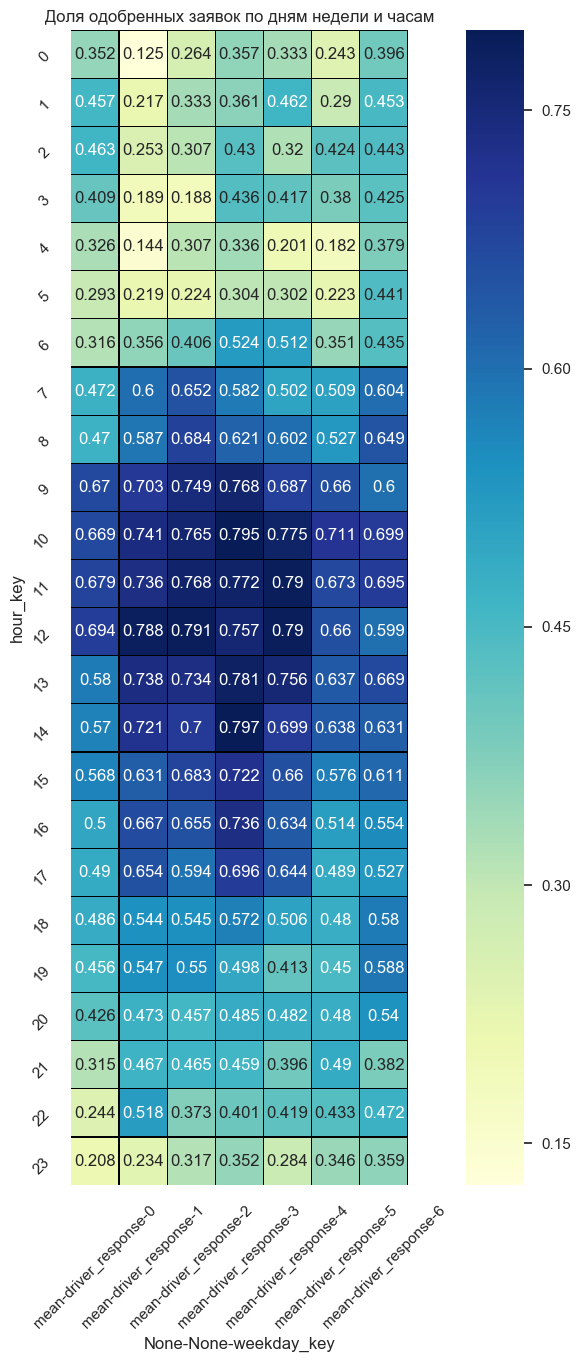

In [7]:
pt_time_m     = pd.pivot_table(data, 
                         values     = ['driver_response'],  
                         index      = ['hour_key'],
                         columns    = ['weekday_key'], 
                         aggfunc    = ['mean'])

sns.set(rc={'figure.figsize':(15,15)})
ax = sns.heatmap(pt_time_m,  
                annot = True, 
                fmt='.3g', 
                cmap= 'YlGnBu', 
                linewidths=0.1, 
                linecolor='black', 
                square=True)

plt.title('Доля одобренных заявок по дням недели и часам')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5)

Видим различия по среднему уровню одобрения заказов в рабочие и выходные дни,  а также по времени суток, выделим дополнительные признаки.

In [8]:
data.loc[ data['hour_key'] > 22,   'hour_type'] = 'h_night'
data.loc[ data['hour_key'] <  6,   'hour_type'] = 'h_night'
data.loc[ (data['hour_key'] > 5) &
          (data['hour_key'] < 9),  'hour_type'] = 'h_morning'
data.loc[ (data['hour_key'] > 8) &
          (data['hour_key'] < 18), 'hour_type'] = 'h_day'
data.loc[ (data['hour_key'] > 17) &
          (data['hour_key'] < 23), 'hour_type'] = 'h_evening'

data.loc[ (data['weekday_key'] == 0), 'day_of rest'] = 1
data.loc[ (data['weekday_key'] == 6), 'day_of rest'] = 1
data.loc[ (data['weekday_key'] > 0) &
          (data['weekday_key'] < 6),  'day_of rest'] = 0

data['hour_type'].value_counts()

h_evening    33103
h_day        32913
h_night      26342
h_morning     7642
Name: hour_type, dtype: int64

Преобразуем наименование признаков дней недели в более читаемый вид 

In [9]:
week_dict = {0 : "Sunday", 1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thurday', 5:'Friday', 6:'Saturday'}
data['weekday_key']  = data['weekday_key'].map(week_dict)

In [10]:
data['weekday_key'].tail()

99995      Sunday
99996      Sunday
99997      Monday
99998    Saturday
99999      Sunday
Name: weekday_key, dtype: object

## offer_class_group

In [11]:
pt_time_ocg     = pd.pivot_table(data, 
                         values     = ['driver_response'],  
                         index      = ['offer_class_group'],
                         aggfunc    = ['count', 'mean'])
pt_time_ocg

,count,mean
,driver_response,driver_response
offer_class_group,,
Delivery,1290,0.677519
Economy,48335,0.439040
Kids,588,0.840136
Premium,1773,0.771574
Standard,47288,0.523494
Test,8,0.750000
VIP,225,0.773333
VIP+,29,0.896552


Test - малое количество наблюдений, круглое значение % одобрений, выглядят как техничесие записи / удалить.

In [12]:
data = data[data['offer_class_group']!= 'Test'] 

В остальном конечно понятна схожесть по логике групп Premium, VIP, VIP+ и XL, по  которым (в целом) зафиксировано наибольшее количество одобрений. В рамках последующей оптимизации модели возможно объединение групп поездок Premium сегмента. 

###  ride_type_desc

In [15]:
pt_time_ocg     = pd.pivot_table(data, 
                         values     = ['driver_response'],  
                         index      = ['ride_type_desc'],
                         aggfunc    = ['count', 'mean'])
pt_time_ocg

,count,mean
,driver_response,driver_response
ride_type_desc,,
SMB,28,0.607143
affiliate,224,0.495536
business,8533,0.593812
private,91207,0.482934


Группы business и SMB различаются по средней результирующего признака, оставим как есть,  рамках последующей оптимизации модели возможно объединение групп поездок. 

## offer_gk

In [16]:
data.offer_gk.value_counts()    #  Поле offer_gk  представляет собой уникальный код заявки, 
                                #  количество уникальных offer_gk соответствует количеству наблюдений
                                #  для анализа непригоден, к удалению
data = data.drop(['offer_gk'], axis = 1)
data.head()

,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response,hour_type,day_of rest
0,Friday,20,6080,174182,55.818842,37.334562,55.814567,37.355010,-1.000,-1.000,Economy,private,0,h_evening,0.0
1,Friday,14,6080,358774,55.805342,37.515023,55.819329,37.466398,18.802,25.217,Standard,private,1,h_day,0.0
2,Saturday,14,6080,866260,55.813978,37.347688,55.814827,37.354074,6.747,9.800,Economy,private,0,h_day,1.0
3,Tuesday,6,6080,163522,55.745922,37.421748,55.743469,37.431130,-1.000,-1.000,Economy,private,1,h_morning,0.0
4,Thurday,16,6080,506710,55.803578,37.521602,55.812559,37.527407,12.383,19.250,Economy,private,1,h_day,0.0


## order_gk

In [9]:
data.order_gk.value_counts()[data.order_gk.value_counts()>1]

853342    14
714527    13
761031    13
828548    12
180487    12
          ..
299976     2
42141      2
201404     2
134811     2
805403     2
Name: order_gk, Length: 9276, dtype: int64

Поле order_gk  представляет собой уникальный код заказа, которому могут соответствовать от 2 до 14 заявок. Выделим признак responce_rate:  количество заказов, соответствеющих уникальной заявке. Затем order_gk удалим за ненадобностью

In [20]:
f_resp_groups = data['order_gk'].value_counts()

data['responce_rate'] = data['order_gk'].apply(lambda x: f_resp_groups.loc[x])
data['responce_rate'].head(3)

0    2
1    1
2    1
Name: responce_rate, dtype: int64

In [21]:
data = data.drop(['order_gk'], axis = 1)

Понятно, что responce_rate имеет сомнительную ценность с точки зрения модели предсказаний. На момент предсказания (если оно осуществляется в режиме реального времени) известно только о части (уже совершенных) откликов на заказ ... будут искажения, показатель буду использовать только справочно / оценочно

##  driver_gk

In [22]:
data.driver_gk.value_counts()

1421    3014
1060    2780
1126    2327
4490    1784
2442    1588
        ... 
2844      52
1978      52
689       52
854       51
3242      50
Name: driver_gk, Length: 439, dtype: int64

Поле driver_gk представляет собой уникальный код водителя, которые работают с различной интенсивностью, которая также может влиять на решение о принятии заказа о поездке

Создадим признак - рейтинг водителя (по количеству рейсов - driver_rate),  Личный идентификатор водителя удалим

In [23]:
f_drive_groups = data['driver_gk'].value_counts()

data['driver_rate'] = data['driver_gk'].apply(lambda x: f_drive_groups.loc[x])
data['driver_rate'].value_counts()

3014    3014
2780    2780
2327    2327
1784    1784
1588    1588
        ... 
79        79
67        67
63        63
51        51
50        50
Name: driver_rate, Length: 240, dtype: int64

In [24]:
data = data.drop(['driver_gk'], axis = 1)
data.shape

(99992, 15)

##  Геоточки :  driver_latitude, driver_longitude, origin_order_latitude, origin_order_longitude


Поля Геоточек могут быть использованы для расчета расстояния между водителем и пассажиром в момент заказа, то есть того расстояния (косвенно - времени), которое следует преодолеть водителю, чтобы приступить к оказанию услуги.  Чем выше такое расстояние - тем выше себестоимость поездки для Водителя,  Водителю менее интересно откликаться на вызов.

Для расчета расстояния нужен полный комплект записей из 4 координат, посмотрим где это не так:

In [25]:
print('Отсутствие координат водителя : ', data[data['driver_longitude']<1].shape[0], ' наблюдений')
print('Отсутствие координат пассажира: ', data[data['origin_order_longitude']<1].shape[0], '  наблюдений')

Отсутствие координат водителя :  141  наблюдений
Отсутствие координат пассажира:  13   наблюдений


Количество неинформативных наблюдений по расстоянию ничножно по сравнению с объемом выборки,  удалим неинформативные записи

In [26]:
data = data.query('driver_latitude > 0')
data = data.query('driver_longitude > 0')
data = data.query('origin_order_latitude > 0')
data = data.query('driver_longitude > 0')
data.shape

(99838, 15)

Посчитаем расстояние, которое должны преодолеть водители, чтобы добраться до клиента, удалим 16 необычно высоких расстояний

In [27]:
def dist_g(r):
    return geodesic (
                    (r['driver_latitude'],       r['driver_longitude']), 
                    (r['origin_order_latitude'], r['origin_order_longitude'])
                    ).km

data['distance_before_order'] = data[
                                    ['driver_latitude', 'driver_longitude',
                                     'origin_order_latitude', 'origin_order_longitude']
                                    ].apply(dist_g, axis = 1)

In [28]:
data = data.query('distance_before_order <=6')
data = data.drop(['driver_latitude', 'driver_longitude', 'origin_order_latitude', 'origin_order_longitude'], axis = 1)
data.describe()

,hour_key,distance_km,duration_min,driver_response,day_of rest,responce_rate,driver_rate,distance_before_order
count,99715.000000,99715.000000,99715.000000,99715.000000,99715.000000,99715.000000,99715.000000,99715.000000
mean,13.829594,18.411039,23.159982,0.491591,0.298822,1.762443,628.190012,0.983189
std,7.307729,41.149084,33.903869,0.499932,0.457744,1.599577,760.680836,0.920262
min,0.000000,-1.000000,-1.000000,0.000000,0.000000,1.000000,50.000000,0.000000
25%,8.000000,-1.000000,-1.000000,0.000000,0.000000,1.000000,165.000000,0.405623
50%,16.000000,10.444000,19.750000,0.000000,0.000000,1.000000,275.000000,0.652998
75%,20.000000,30.686500,37.883000,1.000000,1.000000,2.000000,726.000000,1.316800
max,23.000000,5234.283000,3958.283000,1.000000,1.000000,14.000000,3014.000000,5.991954


##  distance_km

Удаляем очевидные выбросы "сверху" по полю / см describe выше

In [39]:
data[data['distance_km']>100].shape

(173, 12)

In [40]:
data = data.query('distance_km <= 100')

Есть еще выбросы "снизу" - значение которого не может быть / расстояние не может быть отрицательным, оценим масштабы явления

In [38]:
data['distance_km'].value_counts().head(2)

-1.0    26033
 0.0      152
Name: distance_km, dtype: int64

Видим более четверти выборки наблюдений в которых не заявлено расстояние. Выделим no_way (no_distance) наблюдения в отдельный категориальный признак. Признак может понадобиться в дальнейшем для различения записей  по которым изначально были / не были данные (данные получены естественным или расчетным путем, см ниже)

In [39]:
data.loc[ data['distance_km'] < 0, 'no_way'] =1
data.loc[ data['distance_km'] >=0, 'no_way'] =0
data['no_way'].value_counts()

0.0    73682
1.0    26033
Name: no_way, dtype: int64

Попробуем восстановить отсутствующие значения расстояния по значению часа / времени суток поездки , взяв медиану 

In [40]:
f_dist_data = data[data['distance_km'] >= 0]
f_dist_groups = f_dist_data.groupby(['hour_key'])['distance_km'].median()

data.loc[data['distance_km']<0, 'distance_calc'] = data.loc[
                                                   data['distance_km']<0, 'hour_key'].apply(lambda x: f_dist_groups.loc[x])
data.loc[data['distance_km']>=0,'distance_calc'] = data['distance_km']
data['distance_calc'].value_counts()

32.331    2205
27.318    2025
23.475    1763
34.715    1724
18.441    1578
          ... 
26.142       1
34.732       1
35.100       1
25.863       1
0.846        1
Name: distance_calc, Length: 31253, dtype: int64

## duration_min

Логика преобразования признака в точности соответствует distance_km

In [43]:
data = data.query('duration_min <= 85')

In [44]:
data['duration_min'].value_counts().head(1)

-1.0    26033
Name: duration_min, dtype: int64

In [45]:
f_dur_data = data[data['duration_min'] >= 0]
f_dur_groups = f_dist_data.groupby(['hour_key'])['duration_min'].median()

data.loc[data['duration_min']<0, 'duration_calc'] = data.loc[
                                                    data['duration_min']<0, 'hour_key'].apply(lambda x: f_dist_groups.loc[x])
data.loc[data['duration_min']>=0,'duration_calc'] = data['duration_min']
data['duration_calc'].value_counts().head(1)

32.331    2201
Name: duration_calc, dtype: int64

In [ ]:
data = data.drop(['distance_km', 'duration_min'], axis = 1)

(9.0, 0.0)

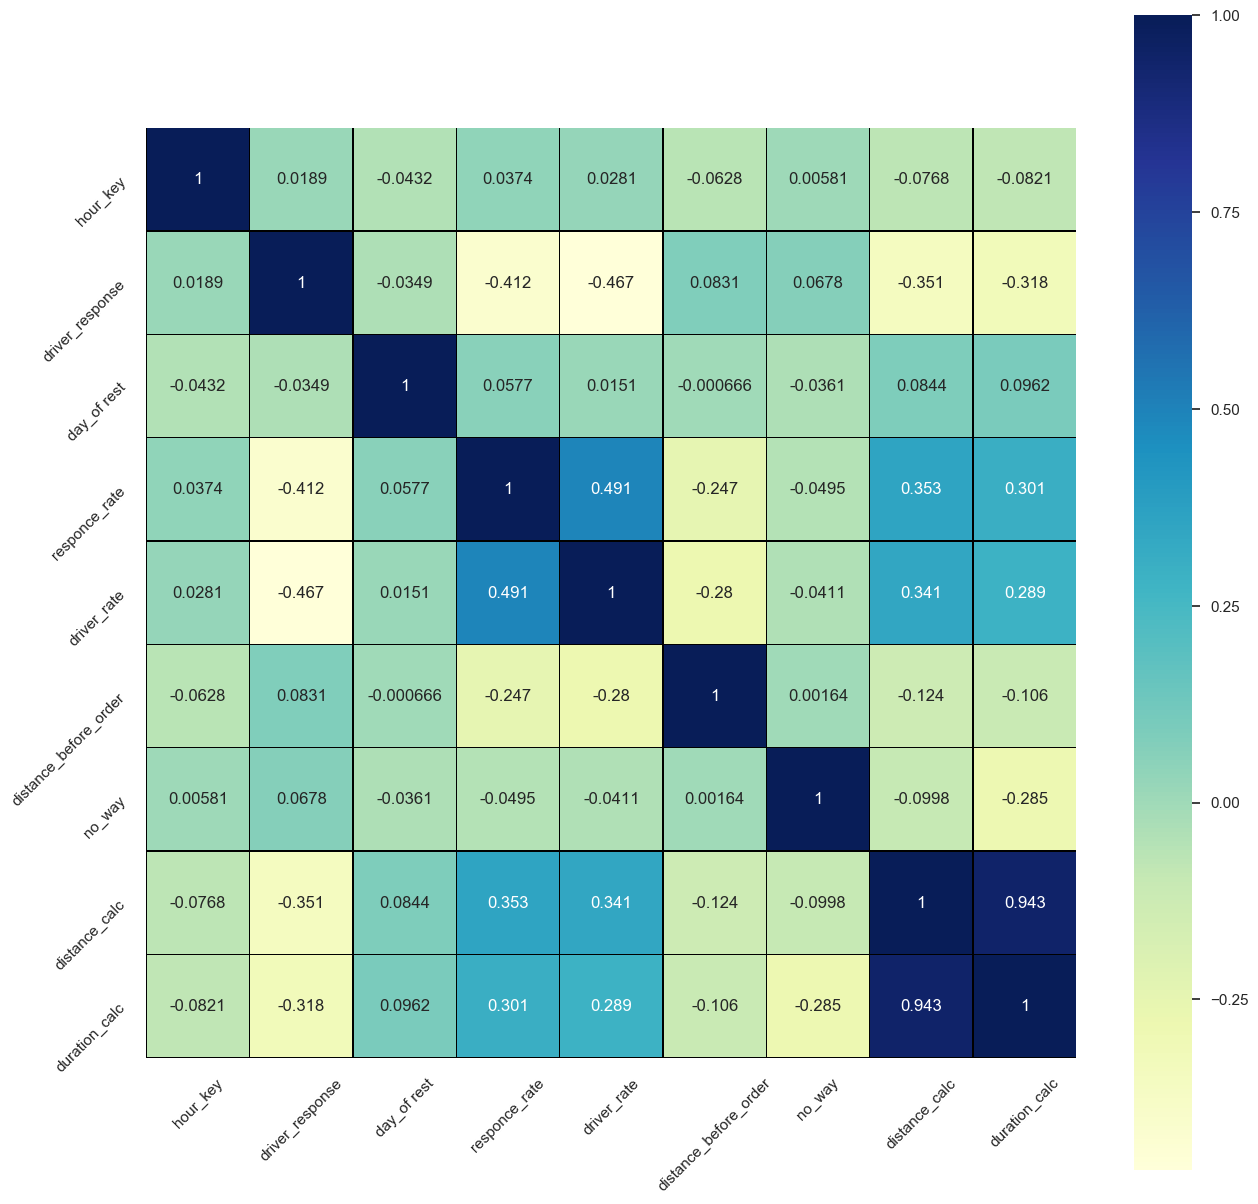

In [48]:
sns.set(rc={'figure.figsize':(15,15)})
ax = sns.heatmap(data.corr(),  
                annot = True, 
                fmt='.3g', 
                cmap= 'YlGnBu', 
                linewidths=0.1, 
                linecolor='black', 
                square=True)

plt.xticks(rotation=45)
plt.yticks(rotation=45)
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5)

По итогам всем преобразований очевидна очень высокая корреляция между показателями  продолжительности поездки и времени поездки,  протестируем на Random Forest  и оставим более информативный,  другой из модели исключим

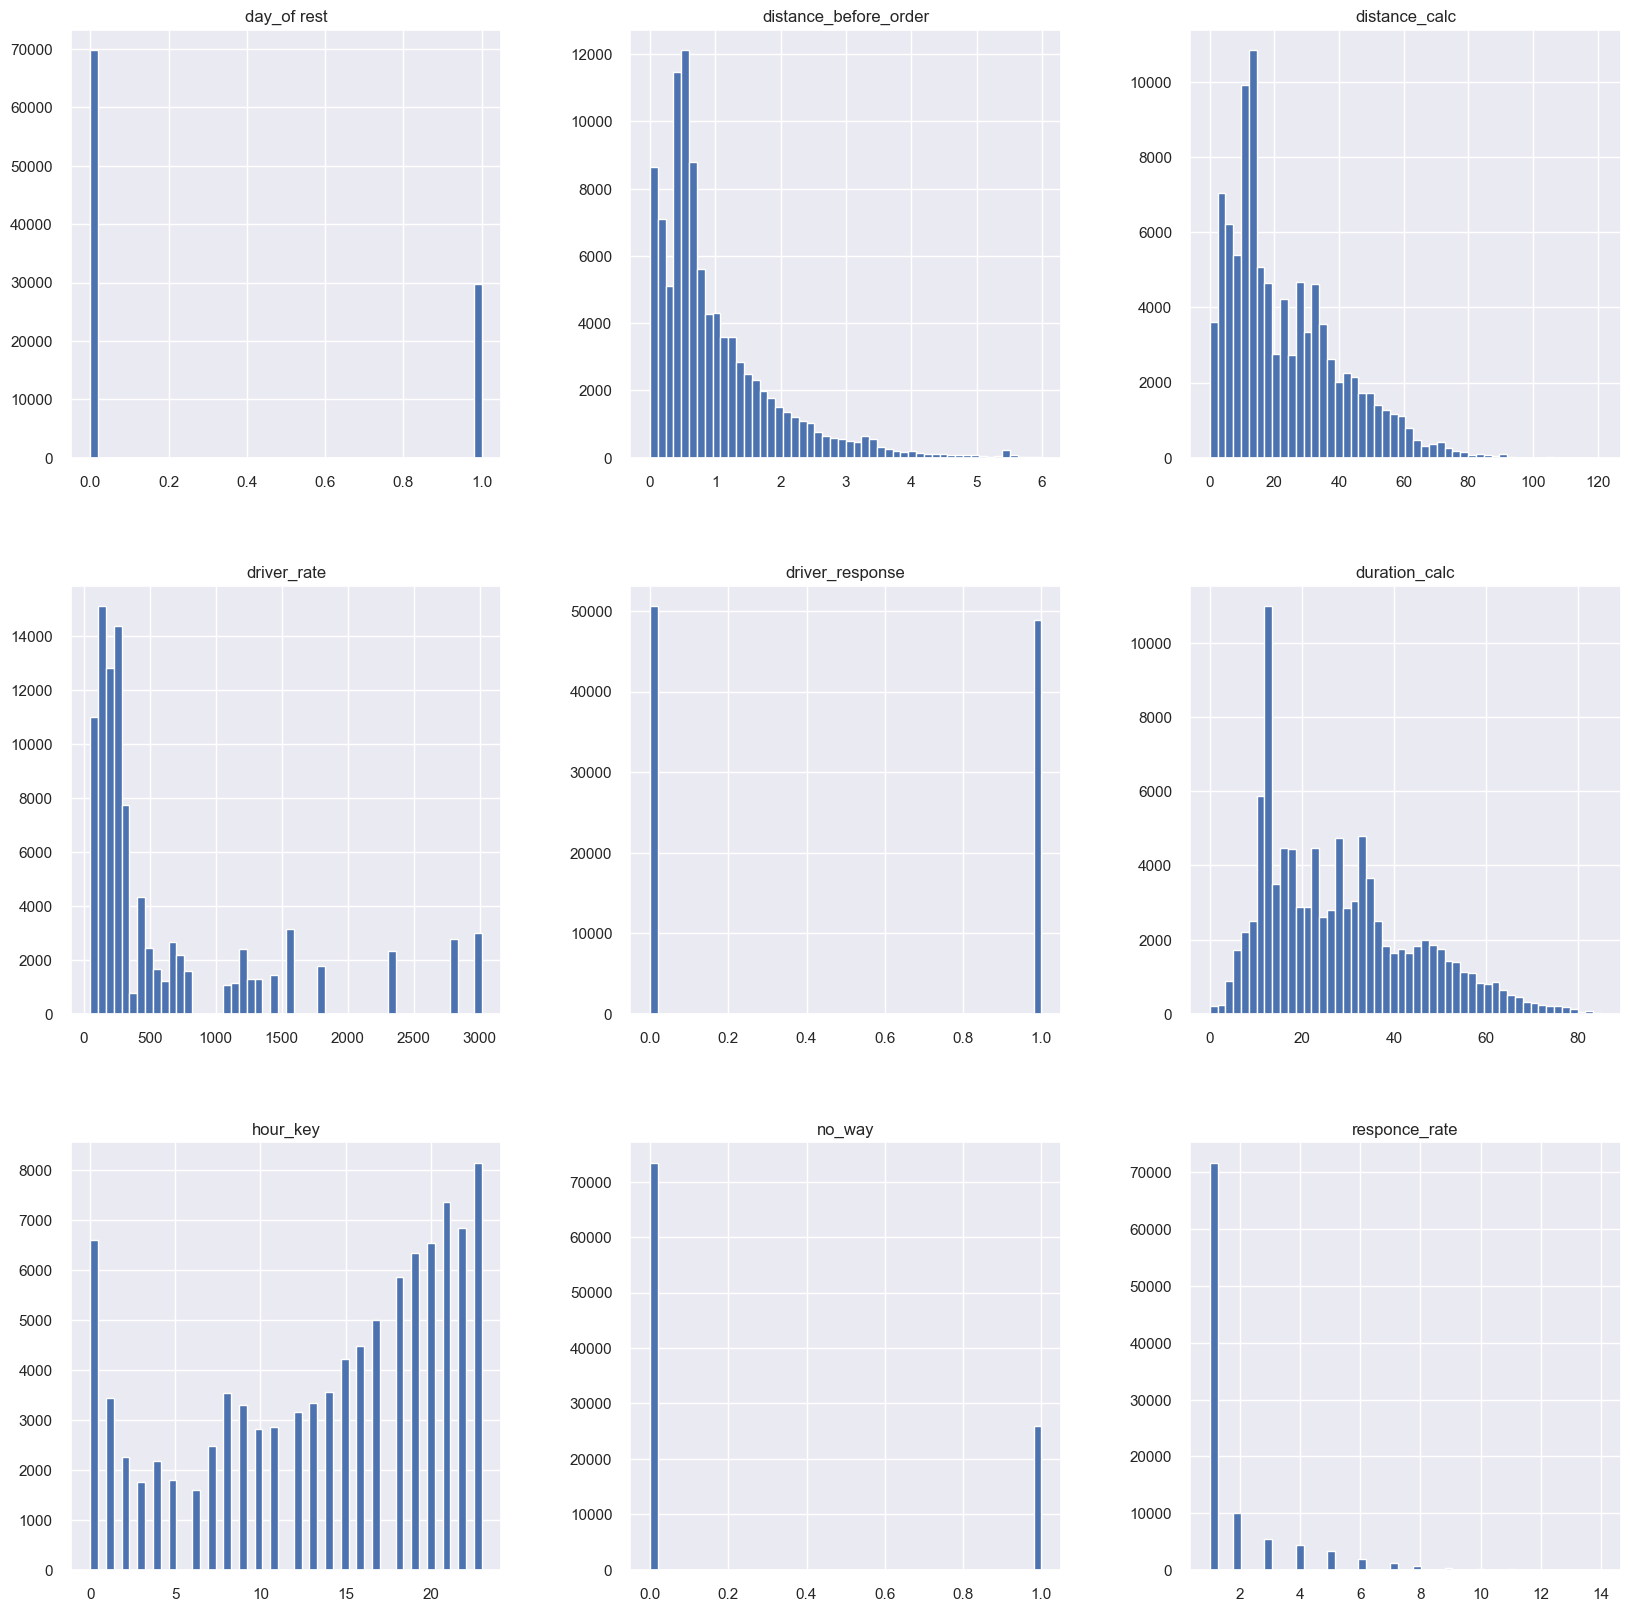

In [49]:
data.hist(figsize=(20,20), bins=50)
plt.show()

##  OneHotEncoding категориальных переменных

In [50]:
cat_data= data[['weekday_key', 'hour_key', 'hour_type', 'offer_class_group', 'ride_type_desc']]
cat_data.head(1)

,weekday_key,hour_key,hour_type,offer_class_group,ride_type_desc
0,Friday,20,h_evening,Economy,private


In [51]:
# преобразуем параметр с помощью one hot encoder
from sklearn.preprocessing import OneHotEncoder

ohe_enc = OneHotEncoder()
ohe_cats = ohe_enc.fit_transform(cat_data).toarray()
ohe_cats = pd.DataFrame(ohe_cats, columns=np.hstack(ohe_enc.categories_))
ohe_cats

,Friday,Monday,Saturday,Sunday,Thurday,Tuesday,Wednesday,0,1,2,...,Kids,Premium,Standard,VIP,VIP+,XL,SMB,affiliate,business,private
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99457,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
99458,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
99459,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
99460,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [52]:
data = data.reset_index().merge(ohe_cats, left_index=True, right_index=True)

In [53]:
data = data.drop(['index', 'weekday_key', 'hour_key', 'offer_class_group', 'ride_type_desc','hour_type'], axis = 1)

In [54]:
Dr_Resp = [0]
WdayAll = [8,9,10,11,12,13,14]
WdaySho = [1]
HourAll = [15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38]
HourSho = [39,40,41,42]
OfClass = [43,44,45,46,47,48,49,50]
RidType = [51,52,53,54]
Dist_1  = [4]
Dist_2  = [6]
Duratio = [7]
DistAll = Dist_1+Dist_2+Duratio
Resp    = [2]
Driver  = [3]
Way     = [5]

In [55]:
def feature_report (feature_col, res_col, d = data, f = 'full'):
    output_y = d.iloc[:,res_col]
    input_x  = d.iloc[:,feature_col]
    le=LabelEncoder()
    targets=(output_y==1)
    Y= le.fit_transform(targets)
    x_train, x_test, y_train, y_test = train_test_split(input_x, 
                                                        Y, 
                                                        test_size = 0.3, 
                                                        random_state = 100)
    model=RandomForestClassifier(n_estimators=100)
    model.fit(x_train,y_train)
    model_pred = model.predict(x_test)
    print('Точность модели составила (%)', 100*model.score(x_test, y_test))
    if f == 'full':
        print(classification_report(y_test, model_pred))
        headers = list(input_x.columns.values)
        feature_imp = pd.Series(model.feature_importances_,index=headers).sort_values(ascending=False)
        f, ax = plt.subplots(figsize=(6, 6))
        sns.barplot(x=feature_imp, y=feature_imp.index)
        plt.xlabel('Уровень значимости параметров')
        plt.ylabel('Параметры')
        plt.title('Рэнкинг значимости параметров')
        plt.show()

Тестирование максимально возможного количества признаков 

C:\Users\admin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Точность модели составила (%) 80.23930019774106
              precision    recall  f1-score   support

           0       0.84      0.76      0.80     15199
           1       0.77      0.85      0.81     14638

    accuracy                           0.80     29837
   macro avg       0.80      0.80      0.80     29837
weighted avg       0.81      0.80      0.80     29837



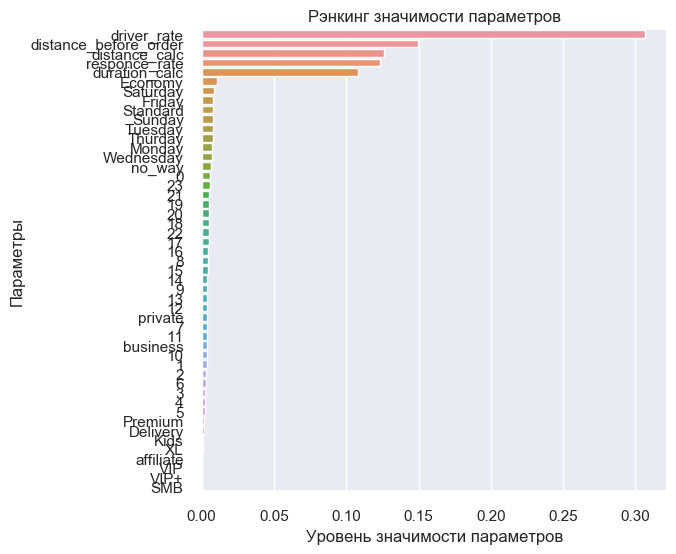

In [56]:
feature_report (
             WdayAll + HourAll + OfClass + RidType + Dist_1 + Dist_2 + Duratio + Resp + Driver + Way, 
             Dr_Resp)

Убираем Duration_calc (высокая корреляция), Responce (сомнительная возможность использования в он лайн прогнозной модели), оставляем дни недели и OfClass получим:

In [57]:
feature_report (
             WdayAll + OfClass + Dist_1 + Dist_2 + Driver, 
             Dr_Resp,
             f = 0)

C:\Users\admin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Точность модели составила (%) 79.4631187372231


Минимальное количество признаков, которое объясняет модель (с сопоставимой точностью) :  будет содержать 3 признака :  расстояние до поездки, расстояние поездки и рейтинг водителя (по количеству заказов)

In [58]:
feature_report (
             Dist_1+ Dist_2 + Driver, 
             Dr_Resp,
             f = 0)

C:\Users\admin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Точность модели составила (%) 78.5247494889239


Оптимальное количество признаков, которое объясняет модель с точки зрения комплексной прогностической ценности в дополнение (к расстоянияю  до поездки, расстоянию поездки и рейтингу водителя)  должно содержать класс заказа и и время суток поездки 

In [60]:
feature_report (
             WdayAll + OfClass + Dist_1 + Dist_2 + Driver, 
             Dr_Resp,
             f = 0)

C:\Users\admin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Точность модели составила (%) 79.45976741847917


Проверим выводы на модели XGboost

In [62]:
def xgbst (feature_col, res_col, d = data):
    output_y = d.iloc[:,res_col]
    input_x  = d.iloc[:,feature_col]
    le=LabelEncoder()
    targets=(output_y==1)
    Y= le.fit_transform(targets)
    x_train, x_test, y_train, y_test = train_test_split(input_x, 
                                                        Y, 
                                                        test_size = 0.3, 
                                                        random_state = 100)
    model=xgboost.XGBClassifier()
    model.fit(x_train, y_train)
    predicted_classes = model.predict(x_test)
    accuracy = accuracy_score(y_test , predicted_classes)
    print('Точность предсказания модели (%): ', accuracy*100)

In [63]:
xgbst (WdayAll + OfClass + Dist_1 + Dist_2 + Driver, Dr_Resp)

C:\Users\admin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Точность предсказания модели (%):  79.241931700124
